In [1]:
library(DBI)
library(RSQLite)
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}

Loading required package: ggExtra

Warning message:
"package 'ggExtra' was built under R version 3.6.2"
Loading required package: naniar

Warning message:
"package 'naniar' was built under R version 3.6.2"
Loading required package: mvoutlier

Warning message:
"package 'mvoutlier' was built under R version 3.6.2"
Loading required package: sgeostat

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

sROC 0.1-2 loaded

Loading required package: MissMech

Loading required package: mice

Warning message:
"package 'mice' was built under R version 3.6.2"
Loading required package: lattice

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind


Loading required package: MatchIt

Wa

In [3]:
load("C:/Users/Guy/Documents/DataScience/Data/movies_ff_v.rdata")

In [4]:
head(movies_ff_v)

,movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
,<int>,<int>,<chr>,<dbl>,<date>,<dbl>,<chr>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,14000000,en,6.575393,2015-02-20,93,Short,12314651,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,40000000,en,8.248895,2004-08-06,113,Medium,95149435,1,0,...,0,0,0,0,0,0,3,0,0,1
3,3,3300000,en,64.299990,2014-10-10,105,Medium,13092000,1,1,...,0,1,0,0,0,0,2,0,0,0
4,4,1200000,hi,3.174936,2012-03-09,122,Large,16000000,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5,0,ko,1.148070,2009-02-05,118,Medium,3923970,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,8000000,en,0.743274,1987-08-06,83,Short,3261638,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
missingMatrix <- function(data) {
    vn <- names(data[,2:85])
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}
getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [5]:
exploreData <- function(y=NULL, data=data, factorSize=10, dir="report", ...) {

  get_computer_type <- function(){
    # check if current R client is running on PC or on the server
    if (Sys.info()[1] == "Windows") {
      computer.type = "pc"
    } else if (Sys.info()[1] == "Linux") {
      computer.type = "server"
    }
    return(computer.type)
  }

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=T),sd=stats::sd(x,na.rm=T))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=T), "<br><u>Max date</u>:",max(x, na.rm=T) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    pl <- stats::scatter.smooth(df$x,col=df$cl)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(aes(x=data[[x]], y=data[[y]]), method="loess") + xlab(x) + ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(aes(y=data[[x]], color=data[[y]])) + xlab(x) + ylab(y) + labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(bp), collapse=', ' )
    }
    imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")
  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  if (get_computer_type()=="pc") {
    srcdir <- paste0(getwd(),"/",report)
  } else {
    srcdir <- paste0("file_show?path=",getwd(),"/",report)
  }
  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      }
      .Row
      {
      display: table-row;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: 'arial';
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)

  for(x in names(data)) {
    print(x)
    html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b></div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)
    #### initialize the first graph
    imgname = paste(fig,"/",x, "_1.png",sep="")
    imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
    ### send the data with the type to generate the correct graph..
    grDevices::png(imgname)
    drawGraphOne(x, data[[x]], data_types[x])
    grDevices::dev.off()
    html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # second, show the statistics
    html <- getStats(data[[x]],data_types[x])
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # third, determine the outliers
    imgname = paste(fig,"/",x, "_2.png",sep="")
    if(data_types[x]==1) {
      grDevices::png(imgname)
      getOutlierGraph(data[[x]])
      grDevices::dev.off()
      html <- getOutliersHtml(x,data[[x]],srcdir)
    } else {
      html <- "<div class='Cell'></div>"
    }
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # fourth, if y is assigned, make a corresponding plot
    if(is.null(y)==FALSE) {
      imgname = paste(fig,"/",x, "_3.png",sep="")
      imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
      #print(imgname)
      grDevices::png(imgname)
      ### scatter.smooth(data[[x]] ~ data[[y]])
      #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
      plot(getScatterGraph(data,x,y,data_types[y]))
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)
    }
    html <- paste("</div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  if(.Platform$OS.type == "unix") {
    system(paste("start /b ", myhtml))
  } else {
    shell(paste("explorer ", gsub("/", "\\\\", myhtml) ), intern=TRUE)
  }
}

###################### END exploreData ###############


In [6]:
##question- 2.1,2.2,2.4,2.5
exploreData(data=movies_ff_v[,c(1:72,74:85)],y="revenue")

[1] "movie_id"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "budget"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "original_language"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "popularity"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_date"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "runtime"


Warning message:
"Removed 4384 rows containing non-finite values (stat_smooth)."


[1] "runtime_cat"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_lang_en"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_web_presence"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_has_poster"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_tagline"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "keyword_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_year"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_month"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "high_release_month"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_day"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "seasonality"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_collection"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "producers_cnt"


Warning message:
"Removed 4531 rows containing non-finite values (stat_smooth)."


[1] "countries_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.04"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.04"
Warning mess

[1] "lang_US"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_FR"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_RU"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_ES"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_JA"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "keywords_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor0_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor0_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor1_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor1_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor2_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor2_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_female_actor0"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_female_actor1"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_female_actor2"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_male_actor0"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_male_actor1"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_male_actor2"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor0_prev_revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5310 rows containing non-finite values (stat_smooth)."


[1] "actor1_prev_revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5534 rows containing non-finite values (stat_smooth)."


[1] "actor2_prev_revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5621 rows containing non-finite values (stat_smooth)."


[1] "director_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "director_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_adventure"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_fantasy"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_animation"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_drama"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_horror"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_action"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_comedy"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_history"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_western"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_thriller"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_crime"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_documentary"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_science_fiction"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_mystery"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_music"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_romance"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_family"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_war"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_foreign"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Art"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


[1] "depart_Camera"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.2111e-014"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.115"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.115

[1] "depart_Crew"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  8.8213e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.595

[1] "depart_Custom_Mkup"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  9.8819e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.165"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.165

[1] "depart_Directing"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.855"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.145"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.4382e-028"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 0.855"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.145"


[1] "depart_Editing"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  4.6794e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.07"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.07"
Wa

[1] "depart_Lighting"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0036"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

[1] "depart_Production"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


[1] "depart_Sound"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


[1] "depart_Writing"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 2"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 2"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(

[1] "depart_Art_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Camera_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Crew_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Custom_Mkup_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Directing_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Editing_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Lighting_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Production_female"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.5653e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.06"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.06"
Wa

[1] "depart_Sound_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Visual_Effects_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Writing_female"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."
Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

Warning message:
"package 'GGally' was built under R version 3.6.2"

Attaching package: 'GGally'


The following object is masked from 'package:dplyr':

    nasa


Warning message in ggcorr(movies_ff_v, method = c("pairwise", "spearman"), nbreaks = NULL, :
"data in column(s) 'original_language', 'release_date', 'runtime_cat' are not numeric and were ignored"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = meth

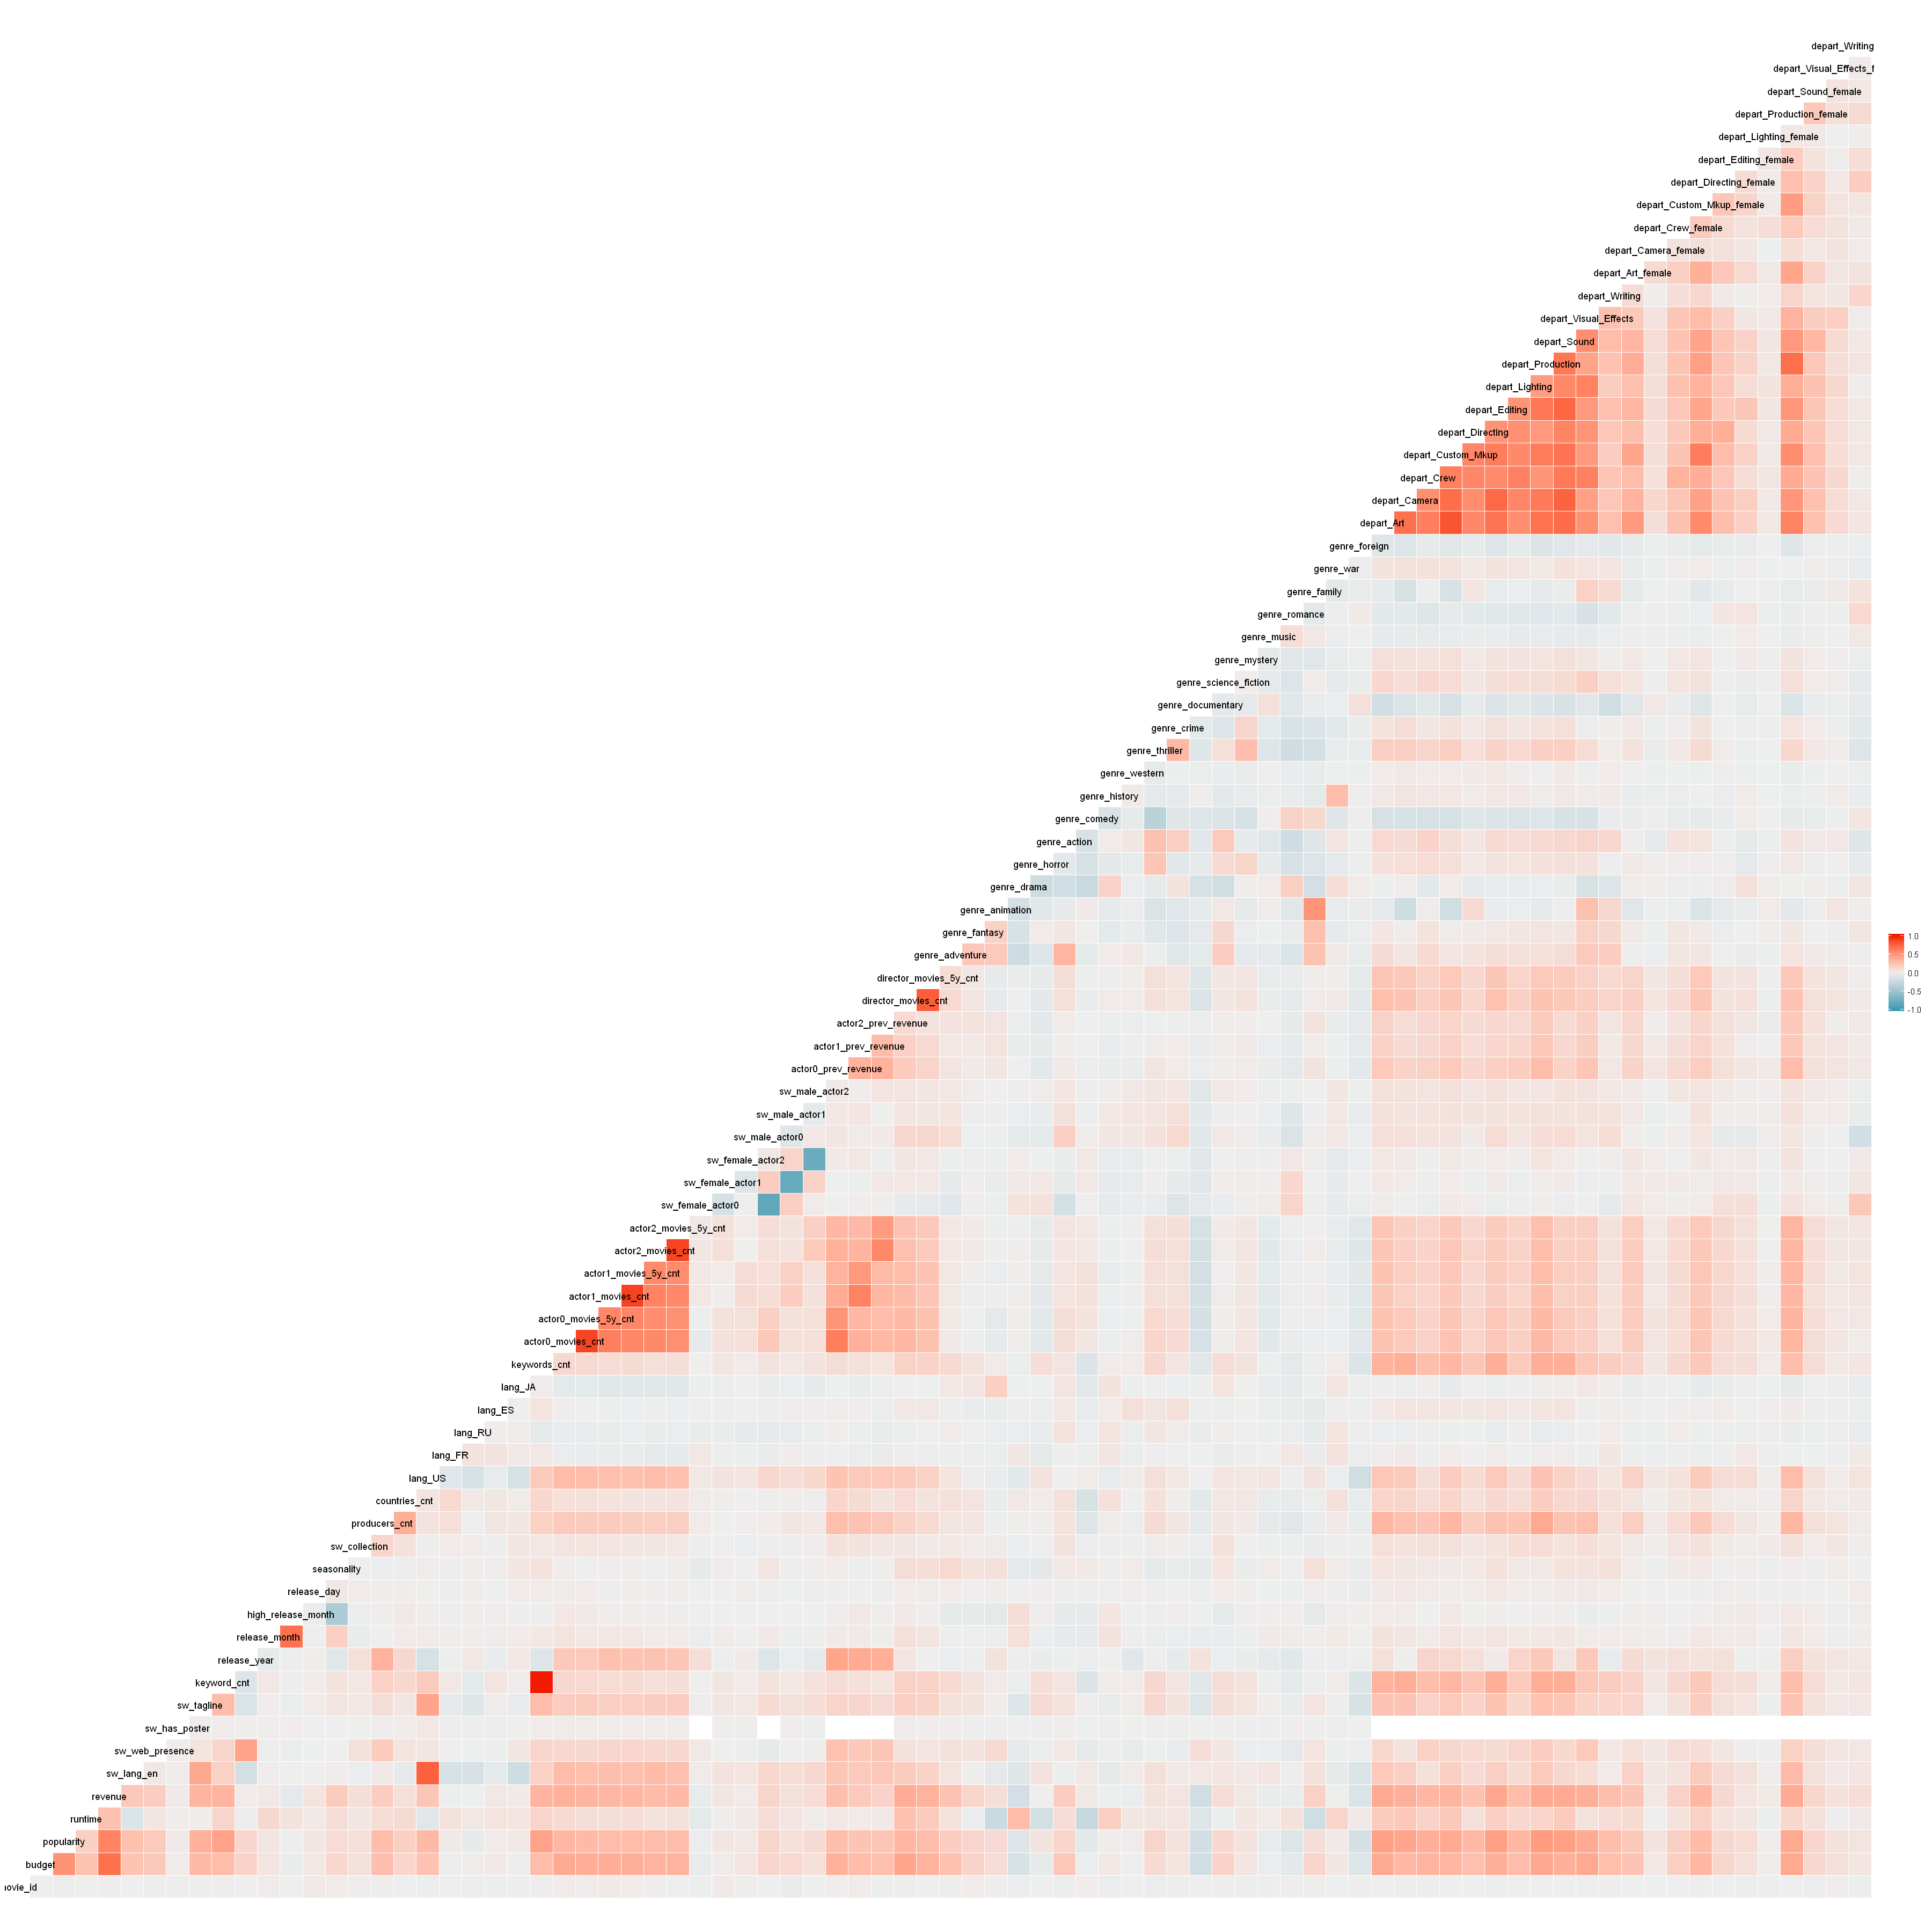

In [7]:
#question2.3 correlation matrix
#install.packages("GGally")
library(GGally)
options(repr.plot.width = 30, repr.plot.height = 30)
ggcorr(movies_ff_v, method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

Warning message in ggcorr(movies_ff_v[, 1:20], method = c("pairwise", "spearman"), :
"data in column(s) 'original_language', 'release_date', 'runtime_cat' are not numeric and were ignored"


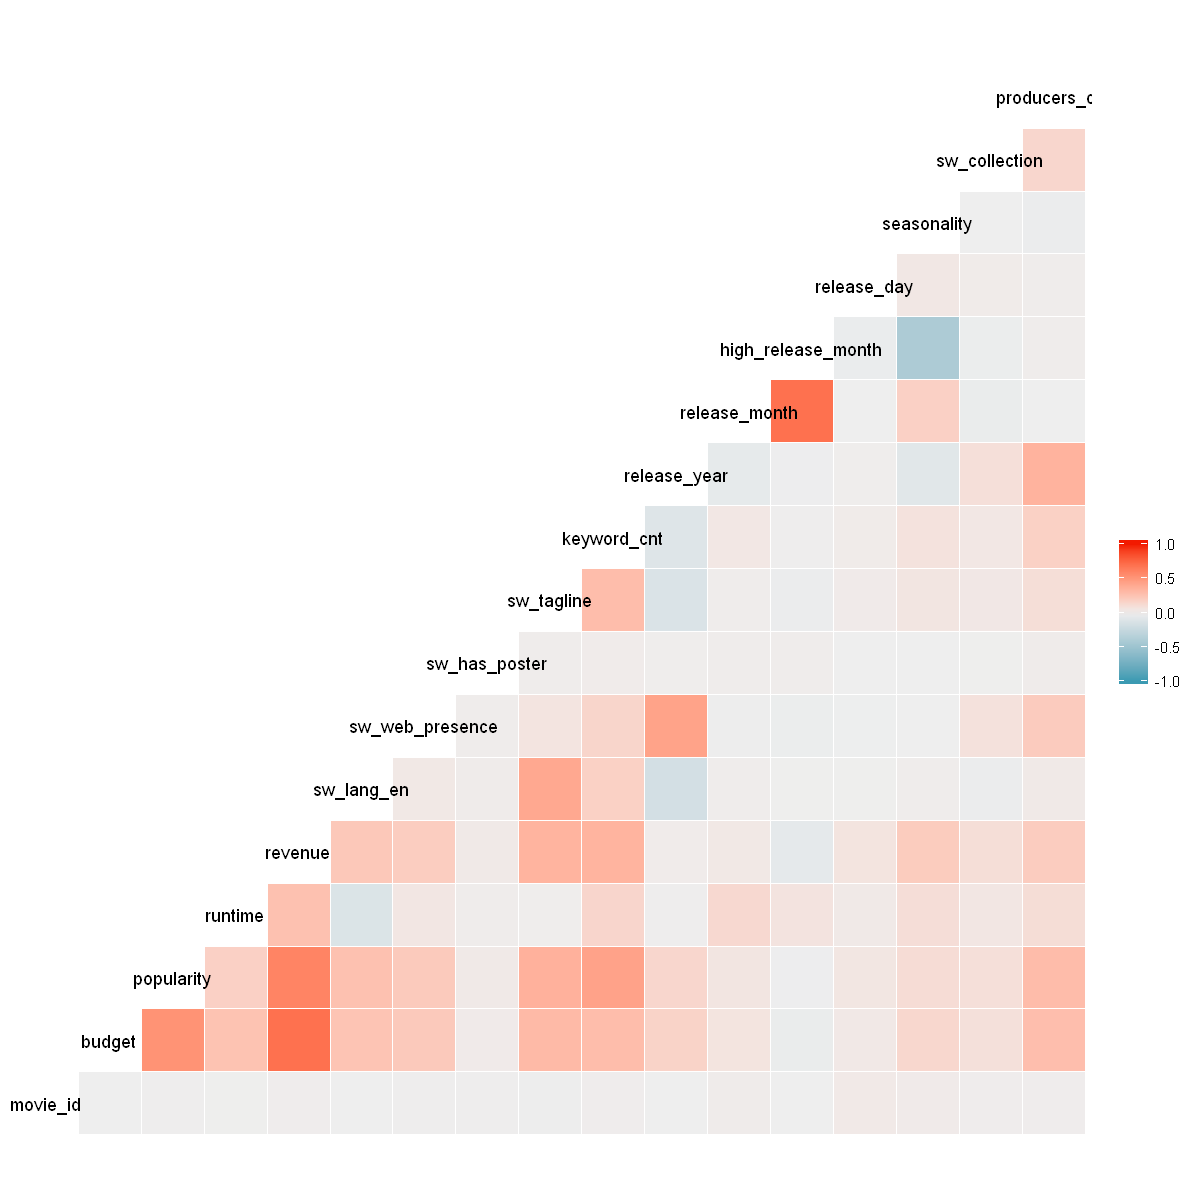

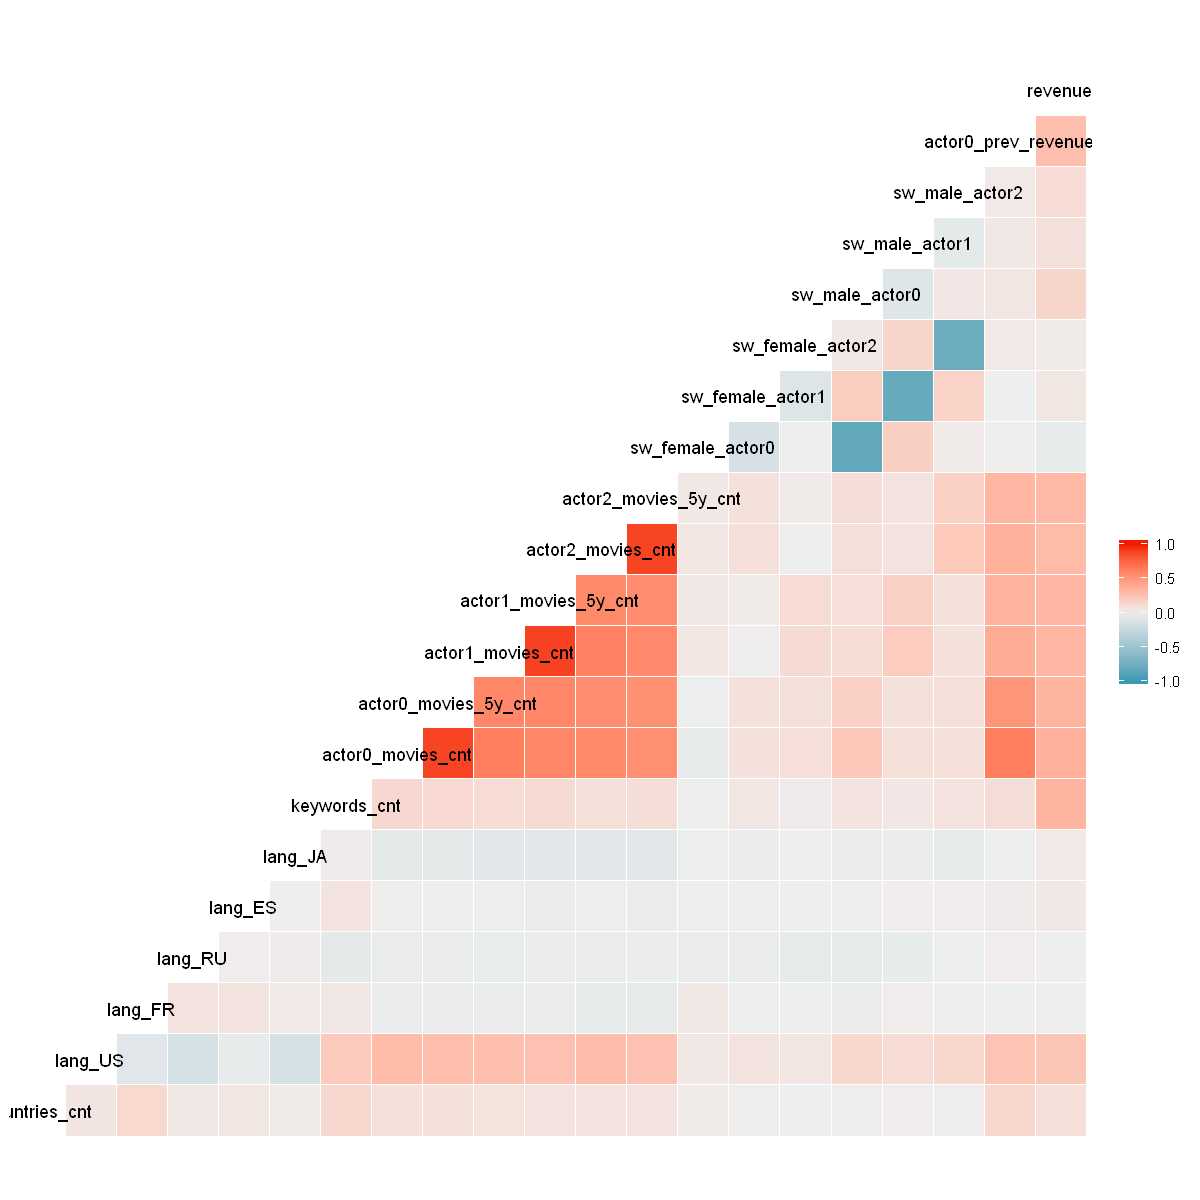

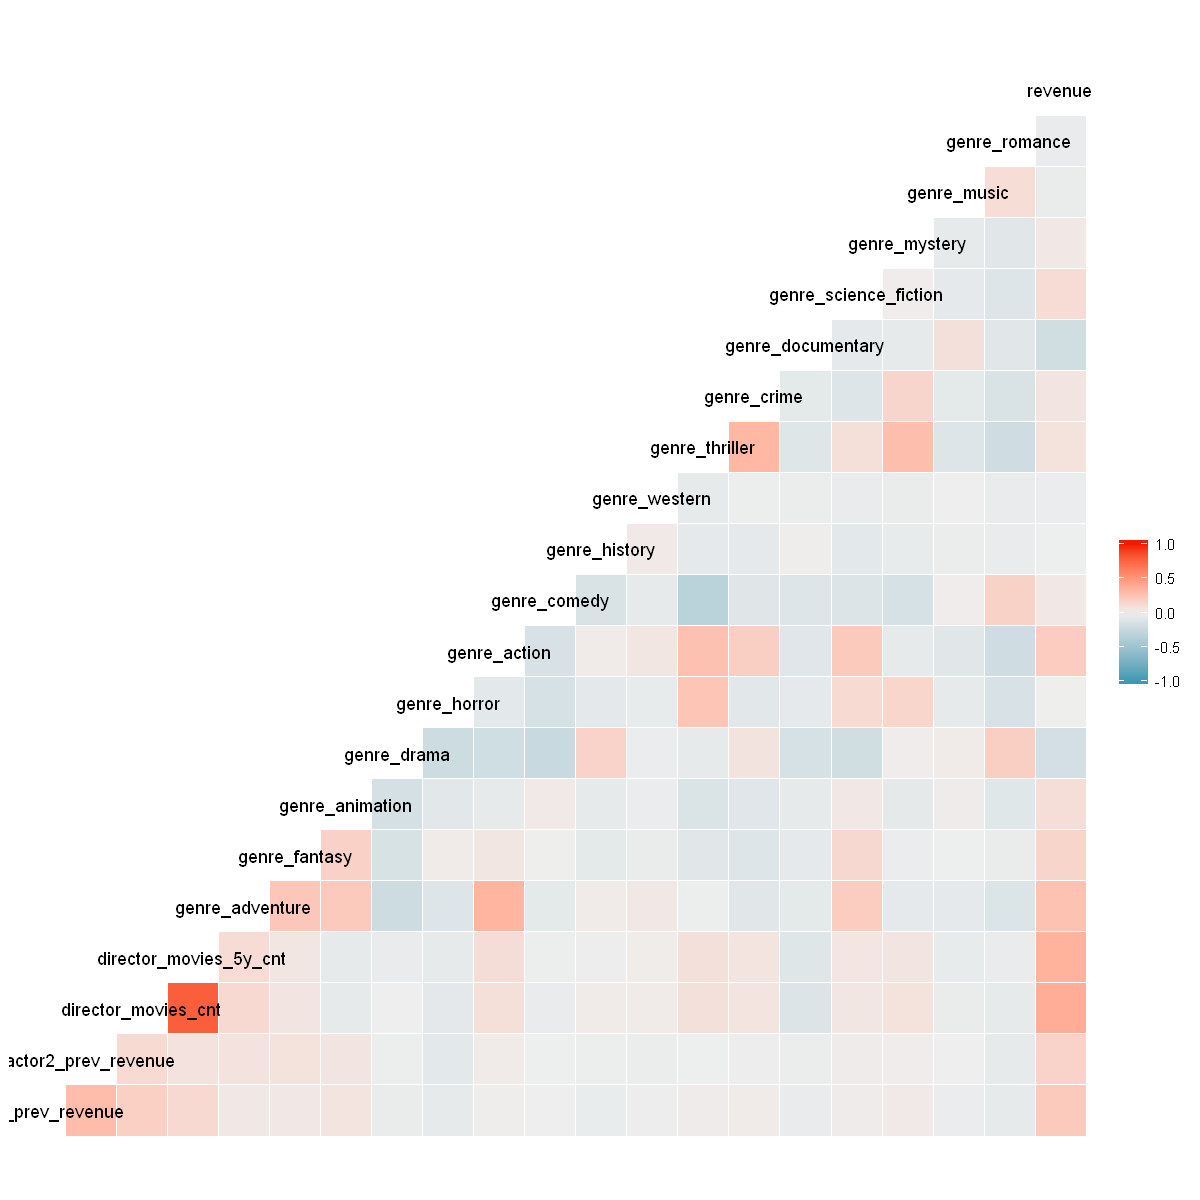

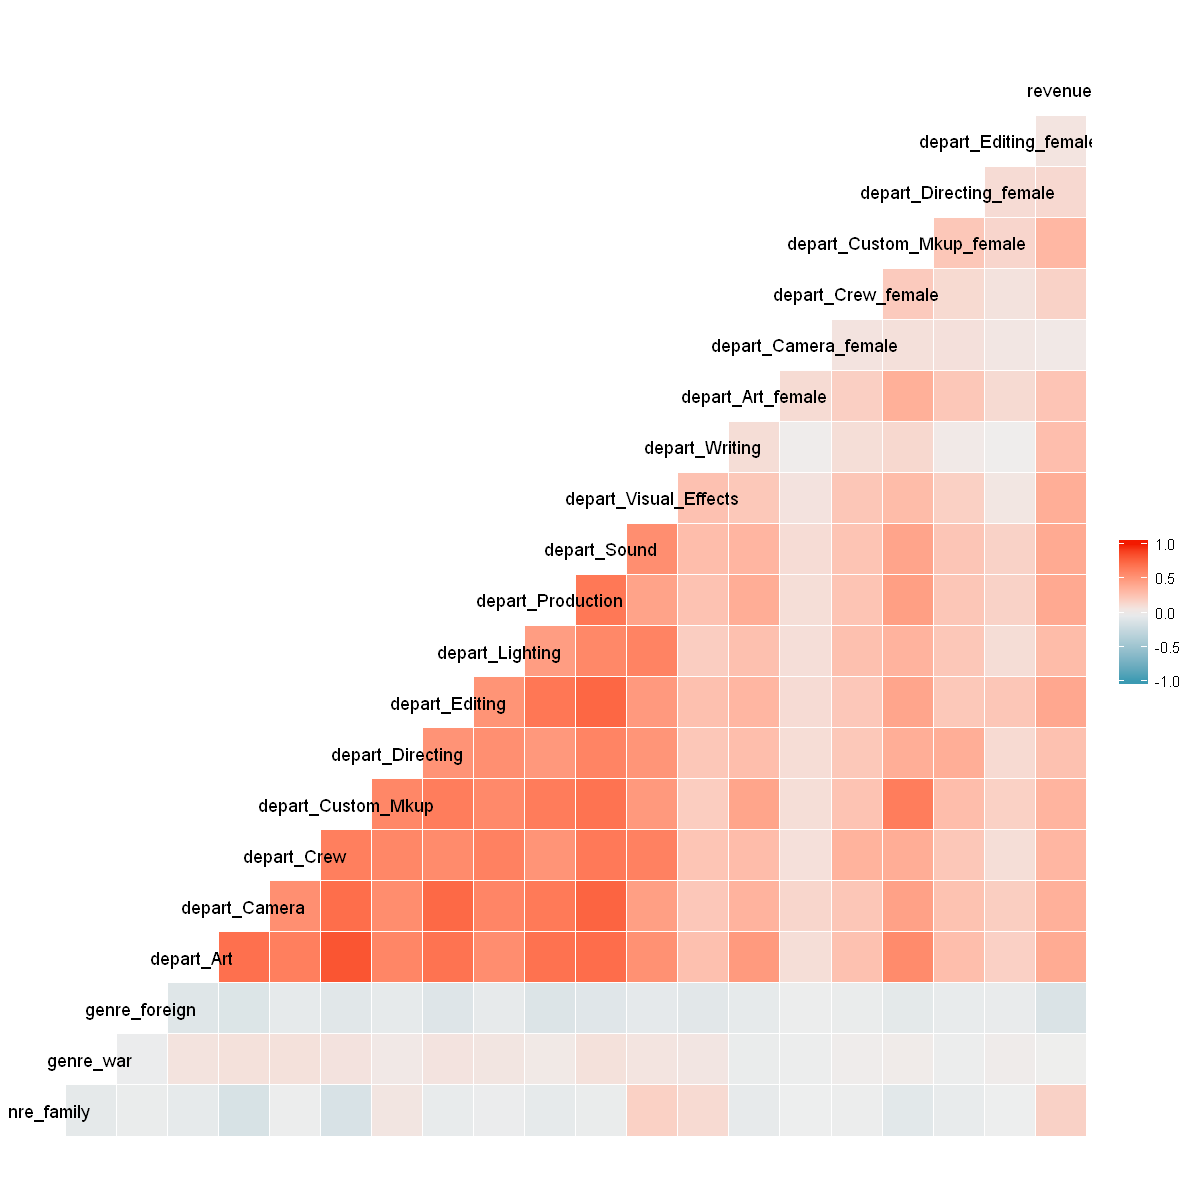

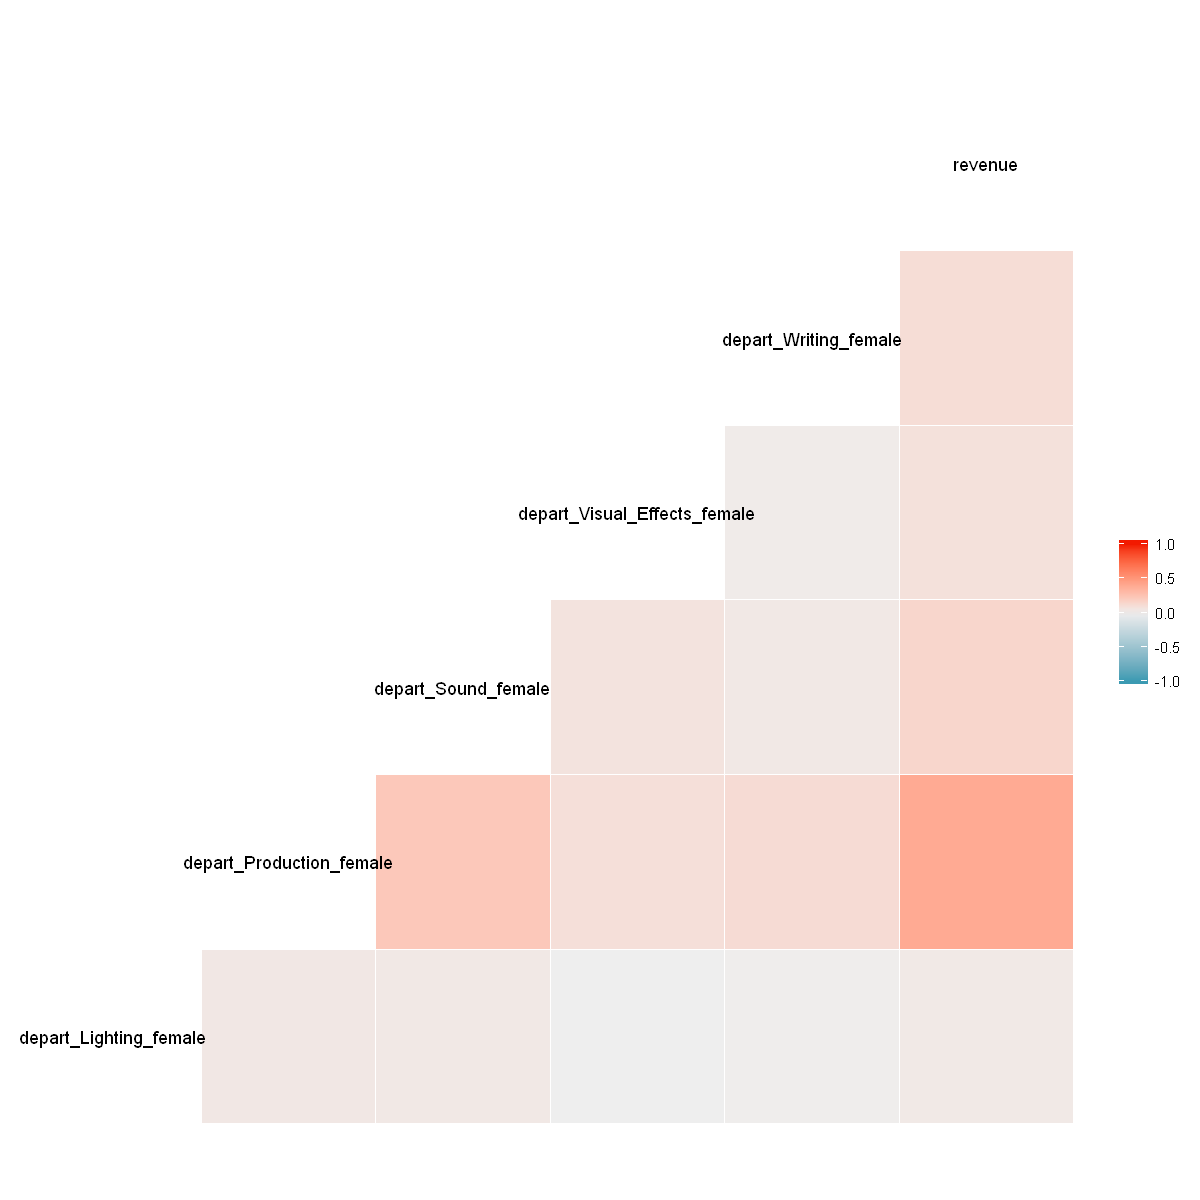

In [21]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggcorr(movies_ff_v[,1:20], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(21:40,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(41:60,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(61:80,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(81:85,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)


In [17]:
#question 2.6- description of the missing values
getMissingness(movies_ff_v)

[[1]]
                   var na.count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3423 46.4
3  actor1_prev_revenue     3201 43.4
4  actor0_prev_revenue     2752 37.3
5     sw_female_actor0      934 12.7
6       sw_male_actor0      934 12.7
7     sw_female_actor2      788 10.7
8       sw_male_actor2      788 10.7
9     sw_female_actor1      782 10.6
10      sw_male_actor1      782 10.6

[[2]]
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."



var,na.count,rate
<fct>,<dbl>,<dbl>
revenue,4382,59.4
actor2_prev_revenue,3423,46.4
actor1_prev_revenue,3201,43.4
actor0_prev_revenue,2752,37.3
sw_female_actor0,934,12.7
sw_male_actor0,934,12.7
sw_female_actor2,788,10.7
sw_male_actor2,788,10.7
sw_female_actor1,782,10.6


In [18]:
#question 2.7 matrix of missing values
movies.miss <- missingMatrix(movies_ff_v)
movies.miss 

budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,sw_has_poster,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Warning message:
"`cols` is now required.
Please use `cols = c(data)`"


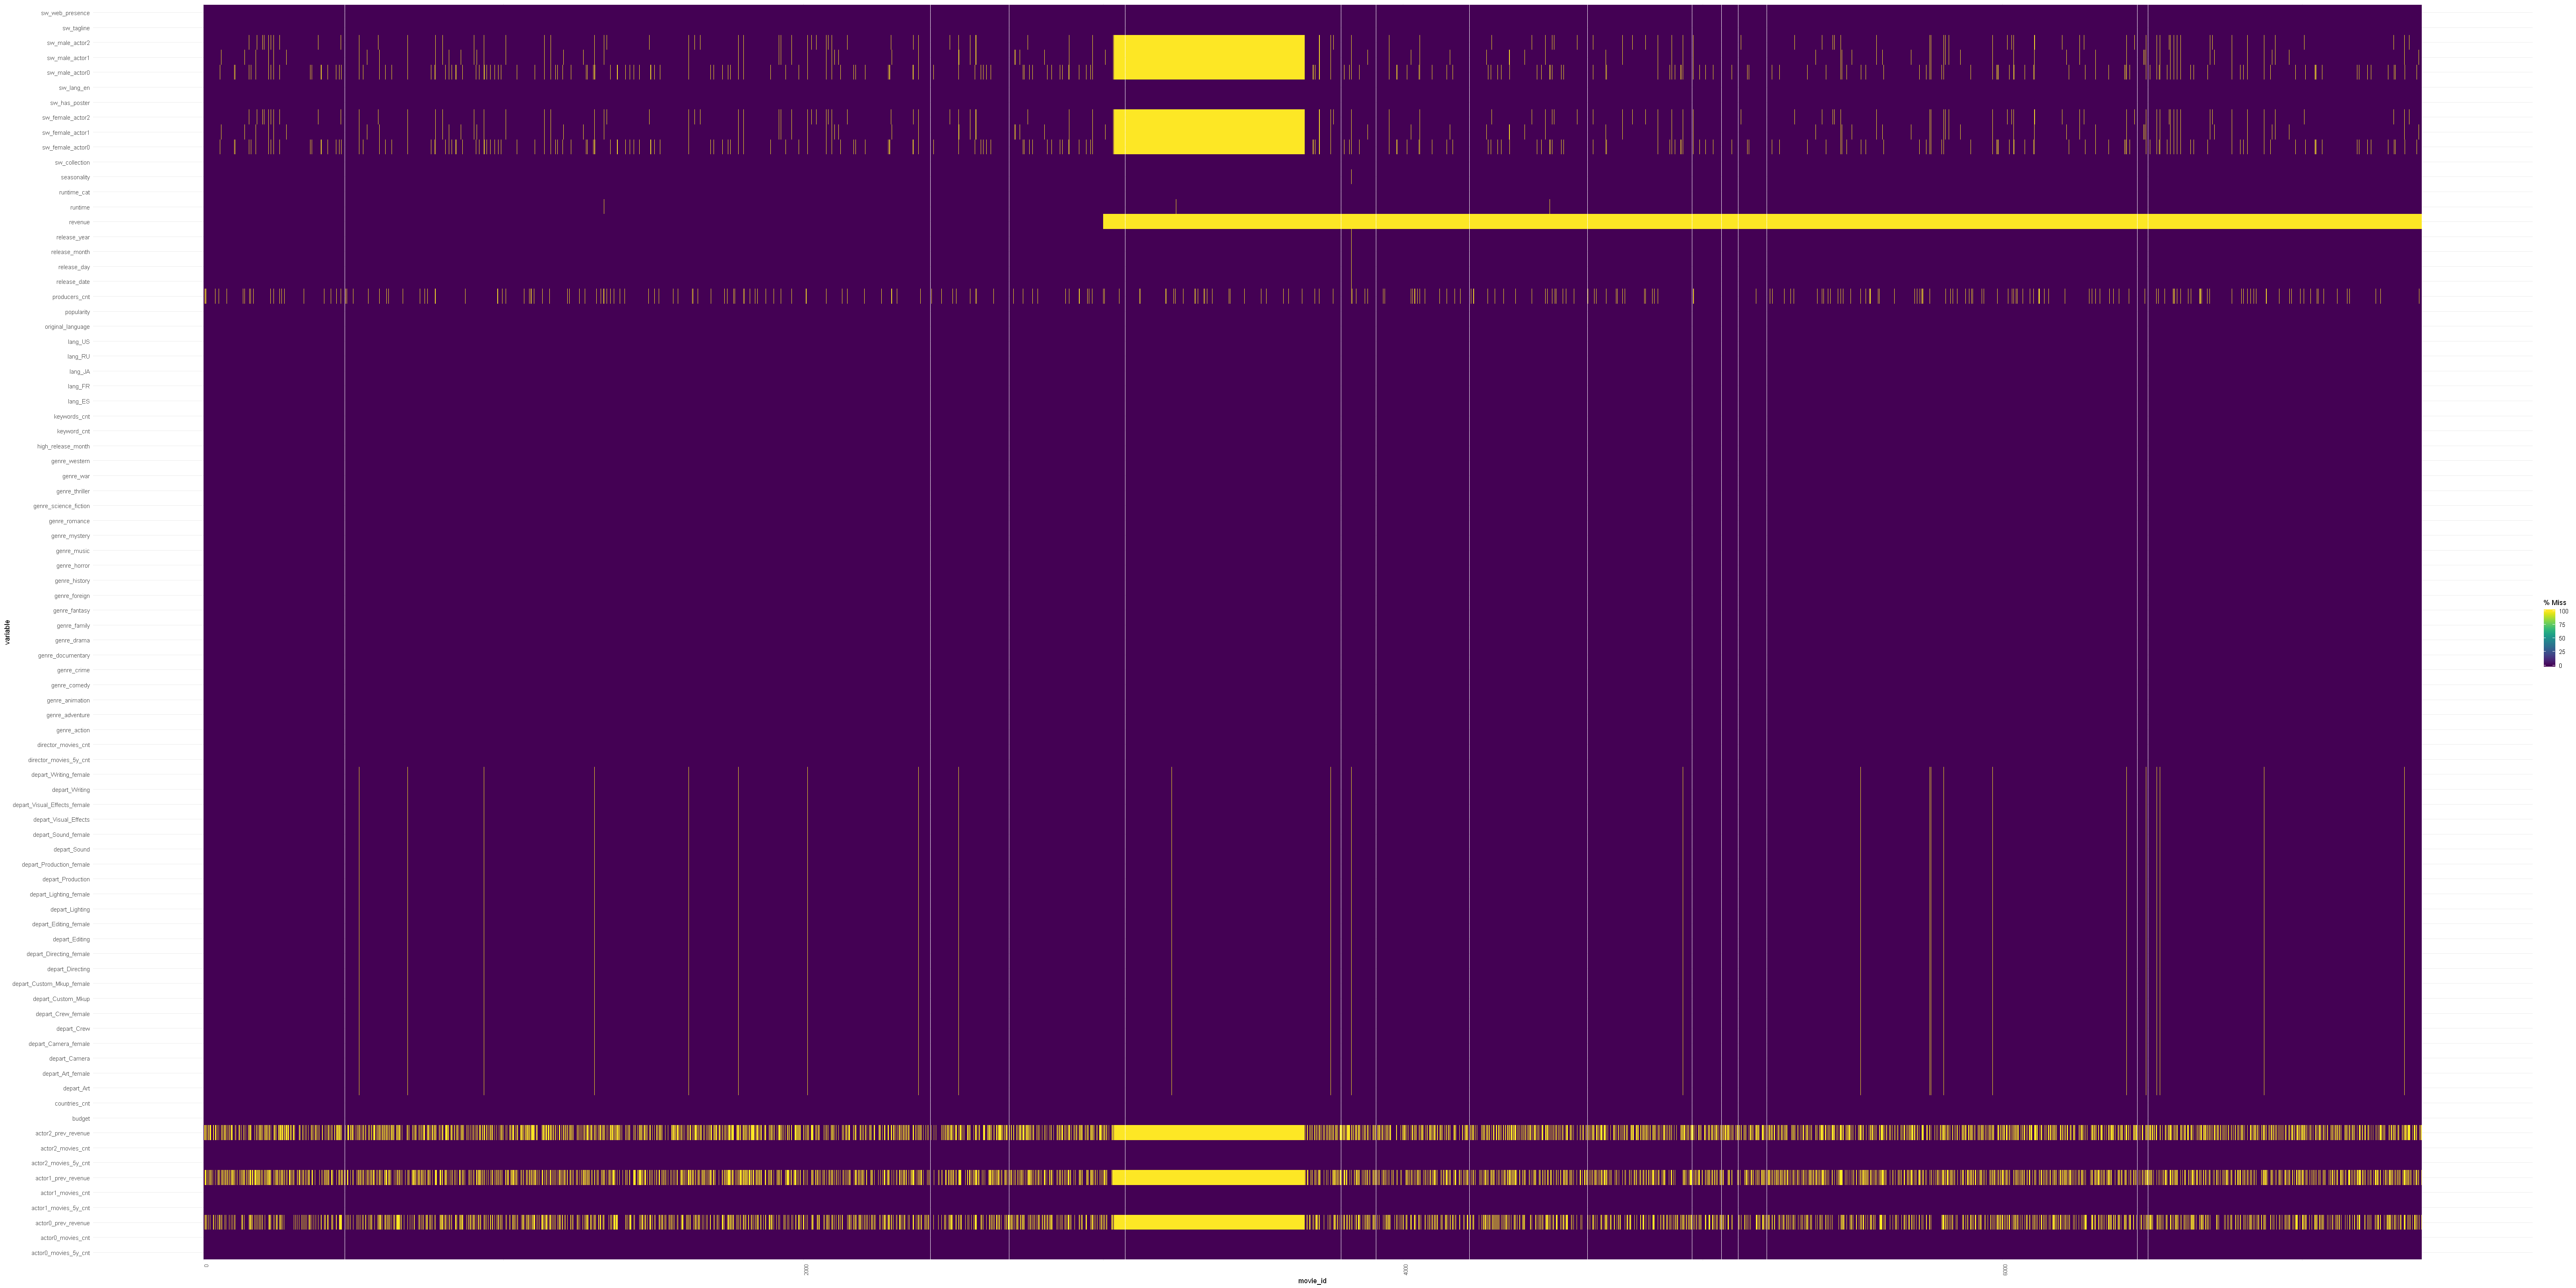

In [19]:
#heatmap of missing values
library(naniar)
options(repr.plot.width = 54, repr.plot.height = 27)
gg_miss_fct(x=movies_ff_v, fct=movie_id) + 
theme(axis.text.x = element_text(angle=90, size=8))

In [46]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            med <- median(data[[v]],na.rm = TRUE)
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[paste(v,"out",sep="_")] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}

In [54]:
movies.out <- outlierMatrix(movies_ff_v)

In [57]:
for (v in names(movies.out))
    {factor (movies.out[[v]])}

In [58]:
movies.out$movie_id=movies_ff_v$movie_id

In [59]:
movies.out

movie_id_out,budget_out,popularity_out,runtime_out,revenue_out,sw_lang_en_out,sw_web_presence_out,sw_has_poster_out,sw_tagline_out,keyword_cnt_out,...,depart_Crew_female_out,depart_Custom_Mkup_female_out,depart_Directing_female_out,depart_Editing_female_out,depart_Lighting_female_out,depart_Production_female_out,depart_Sound_female_out,depart_Visual_Effects_female_out,depart_Writing_female_out,movie_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5
0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6
0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,7
0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,8
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [60]:
joined.movies.outliers<-full_join(movies_ff_v,movies.out,by="movie_id")
head(joined.movies.outliers)

,movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female_out,depart_Crew_female_out,depart_Custom_Mkup_female_out,depart_Directing_female_out,depart_Editing_female_out,depart_Lighting_female_out,depart_Production_female_out,depart_Sound_female_out,depart_Visual_Effects_female_out,depart_Writing_female_out
,<int>,<int>,<chr>,<dbl>,<date>,<dbl>,<chr>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,14000000,en,6.575393,2015-02-20,93,Short,12314651,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,40000000,en,8.248895,2004-08-06,113,Medium,95149435,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3,3300000,en,64.299990,2014-10-10,105,Medium,13092000,1,1,...,0,1,0,0,0,0,0,0,0,0
4,4,1200000,hi,3.174936,2012-03-09,122,Large,16000000,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5,0,ko,1.148070,2009-02-05,118,Medium,3923970,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,8000000,en,0.743274,1987-08-06,83,Short,3261638,1,0,...,0,0,0,0,0,0,0,0,0,0


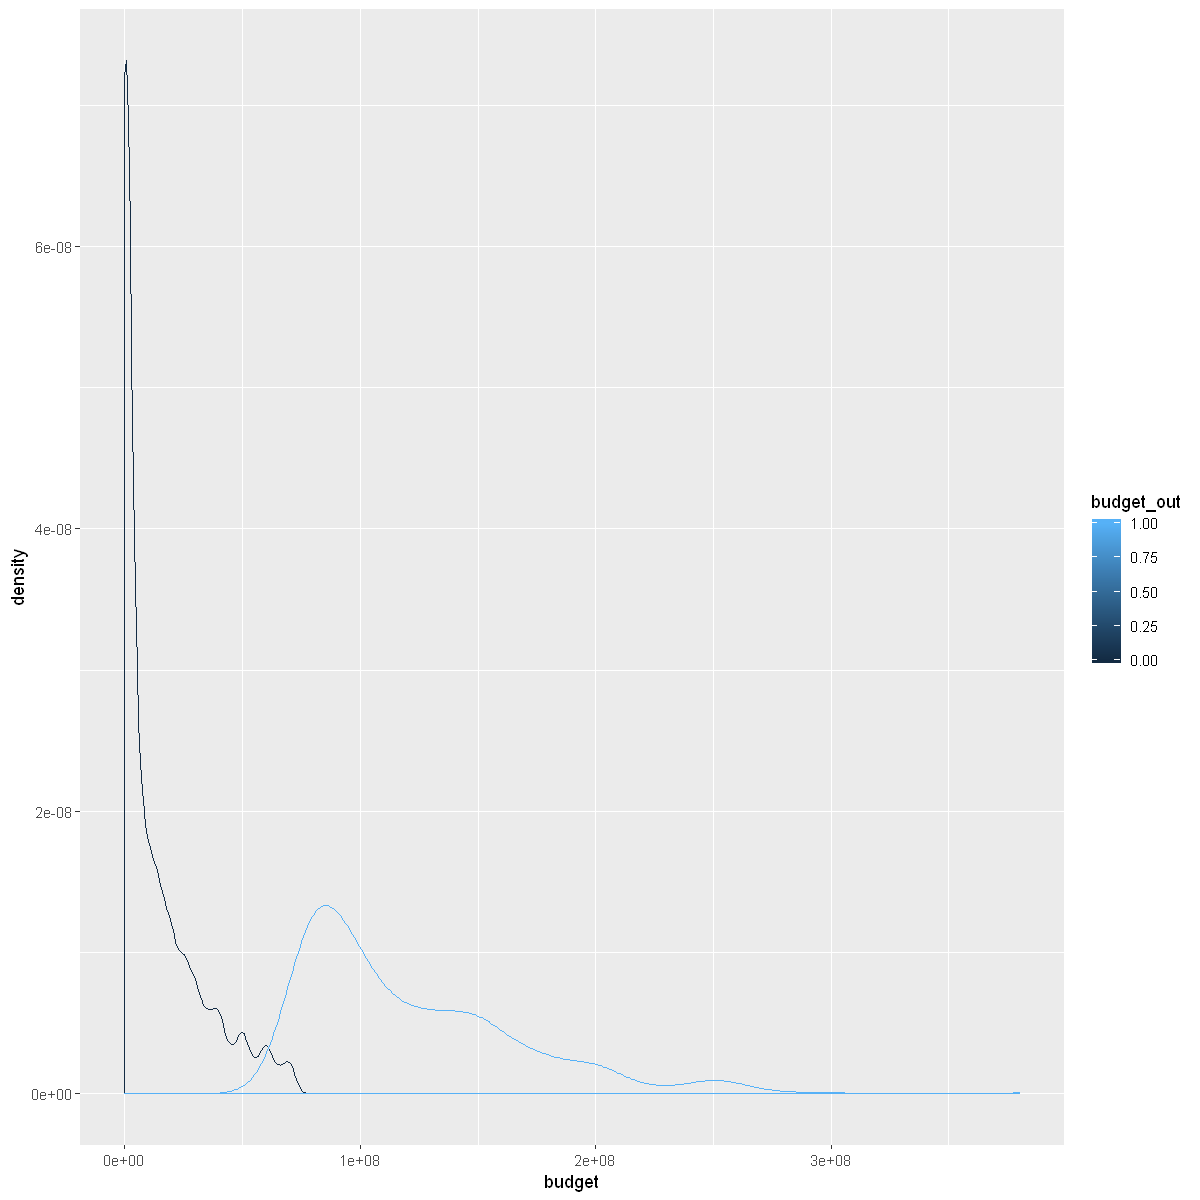

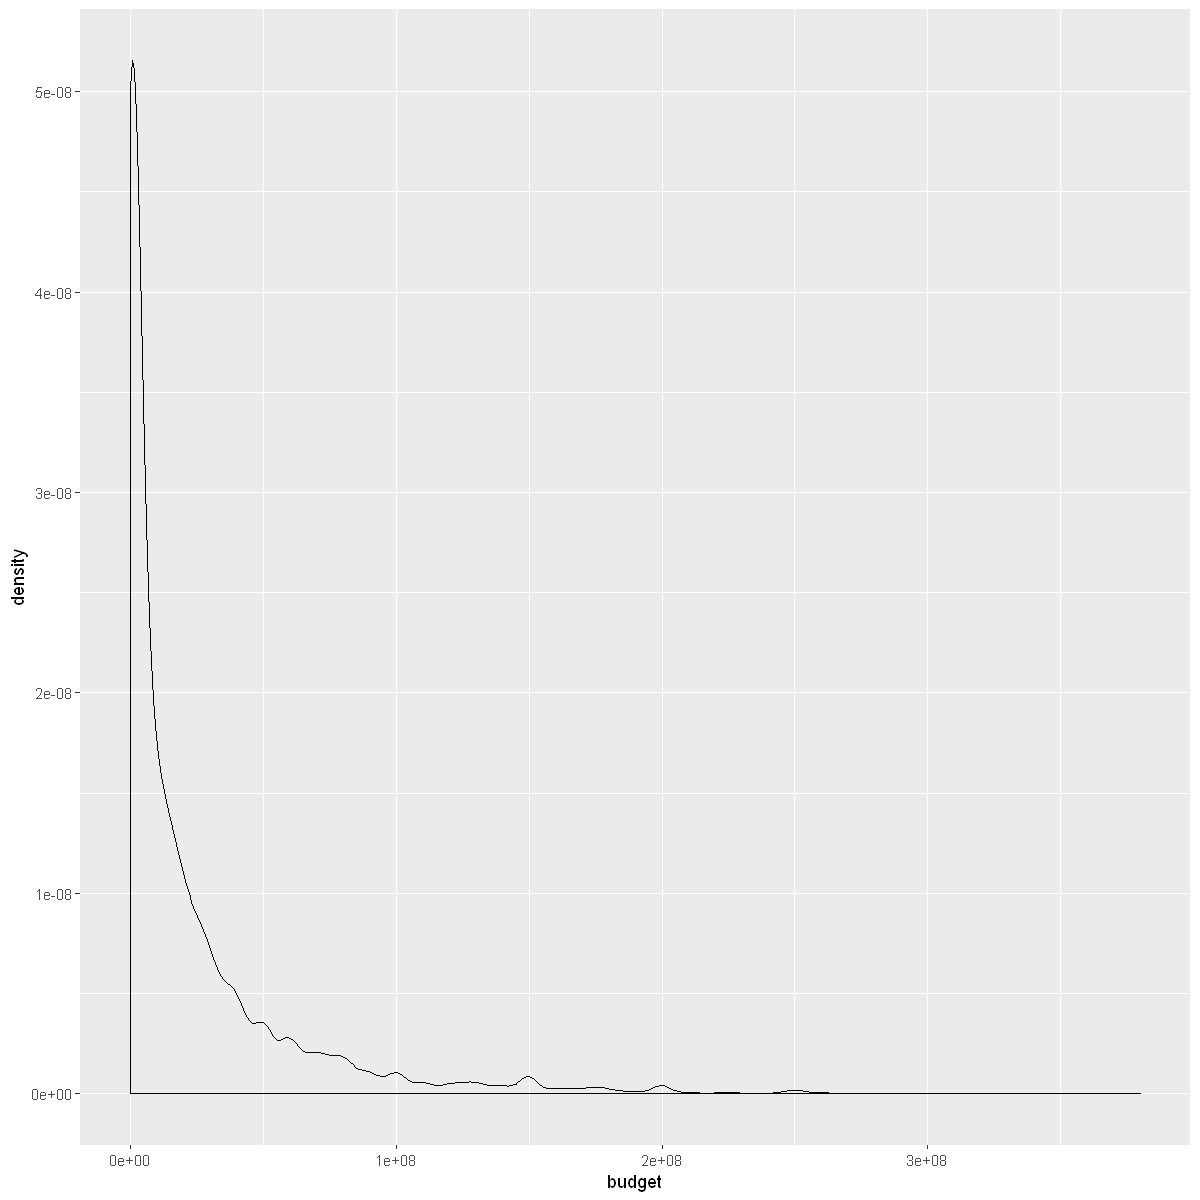

In [64]:
ggplot(data=joined.movies.outliers) +
    geom_density(aes(x=budget, group=budget_out, color=budget_out))
ggplot(data=joined.movies.outliers)+
    geom_density(aes(budget))